In [ ]:
# default_exp diffusion_flow_embedding
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

In [ ]:
# export
# hide
import torch
import torch.nn as nn

# Flow Embedding with Diffusion

The first generation of the flow embedding network was based around the preservation of distances in the embedding space. It's now obvious that this was the wrong tact. Caring about distance preservation puts most emphasis on far away points (including pathological cases, when there's no connectivity and the distance is "infinite"). 

Affinities do the trick here much better. They naturally emphasize only local distances, and allow the network to heavily discount (if not outright ignore) long-range connectivity. 

This locality creates a new model of flow. Previously, our network used euclidean lines between points, and used the flow only to determine the length of each line. Going against (and especially, going perpendicular) to the flow was *possible*, just not easy.

With the diffusion-based model, we think in terms of probabilities, rather than distances. 
This has a couple of downstream effects:
- Going with the flow is *highly* encouraged. Going against or even perpendicular is given (depending on the kernel function used) a probability close to zero.
- Points travel on *paths* dictated by the flow. The likelihood of reaching point $i$ from $j$ is governed not by the *shortest* path, but the aggregate of all paths, weighted by probability. This has the dual effects of diminishing the effect of outliers, and providing an intuitive model of motion. You don't have to reason about which path is "lowest energy", just which path is most likely based on the directions of flow.

## The Pieces of the Algorithm

We compute the probabilities of transition between the points with three steps:
1. Learn a "Flow Artist": a neural network to learn flow over the euclidean field.
  - This is currently a function of two variables $F(x,y): \mathbb{R}^2 \to \mathbb{R}$. The direction of flow is the negative gradient $-\Delta F$.
2. Compute the probabilities of transition between the grid points and the embeddings of points.
3. Compute the probabilities of transition from grid points to grid points.

The probability of transitioning from one point to another is then the amalgam of these steps: we transition to the grid, transition within the grid for $t$ steps, and then transition back to a point. Each probability gives a matrix.

## Probability Kernel from Flow

The foundation of these is the conversion from *flow* (the vector field) to probabilities of transition. This is done using a kernel based on the degree of divergence between the direction specified and the flow, as below, where $r$ is the flow direction (a vector) and $v$ is the direction of the edge.
$$ e^{-(\|r\|^2 - r \cdot v)/\sigma} $$
When the flow is aligned with the direction, this returns 1. When it is perpendicular, $e^{-\|r\|^2/\sigma}$, and when against the flow, $e^{-2\|r\|^2/\sigma}$.

We should tune $\sigma$ to ensure that a 45 degree angle returns a quantity significantly above zero.

We'll create a function that performs this operation on batches of flows and directions. The input will be an array of flows (e.g. the flow per point), and a batch of directions (e.g. NESW for each point). It will, of course, use PyTorch for backpropogation capable operations

In [ ]:
a = torch.rand(10,2)
b = torch.rand(4,10,2)
a

tensor([[0.8946, 0.5463],
        [0.7522, 0.0148],
        [0.0908, 0.0139],
        [0.2149, 0.8459],
        [0.8517, 0.7275],
        [0.7860, 0.4420],
        [0.1877, 0.2564],
        [0.7948, 0.4543],
        [0.9502, 0.0671],
        [0.6981, 0.5650]])

In [ ]:
b

tensor([[[0.6313, 0.1965],
         [0.3358, 0.5033],
         [0.5095, 0.0391],
         [0.3363, 0.6521],
         [0.8074, 0.2792],
         [0.7595, 0.1175],
         [0.9216, 0.4588],
         [0.4332, 0.3004],
         [0.5700, 0.5408],
         [0.2259, 0.3619]],

        [[0.9815, 0.6022],
         [0.7698, 0.8830],
         [0.8008, 0.2901],
         [0.3351, 0.8947],
         [0.9963, 0.8627],
         [0.9498, 0.4384],
         [0.7044, 0.6547],
         [0.7867, 0.0879],
         [0.0455, 0.9758],
         [0.0345, 0.2223]],

        [[0.7887, 0.4502],
         [0.8803, 0.5009],
         [0.0923, 0.6151],
         [0.1794, 0.2279],
         [0.9858, 0.3328],
         [0.7548, 0.8217],
         [0.2500, 0.0546],
         [0.2648, 0.3524],
         [0.9853, 0.3054],
         [0.5371, 0.6696]],

        [[0.7334, 0.8944],
         [0.3859, 0.1035],
         [0.1948, 0.9033],
         [0.5854, 0.5692],
         [0.3758, 0.5837],
         [0.2569, 0.0938],
         [0.9348, 0.79

In [ ]:
anorm = torch.linalg.norm(a, dim=-1)[:,None].repeat(4,1,2)
anorm

tensor([[[1.0482, 1.0482],
         [0.7524, 0.7524],
         [0.0919, 0.0919],
         [0.8727, 0.8727],
         [1.1201, 1.1201],
         [0.9018, 0.9018],
         [0.3178, 0.3178],
         [0.9155, 0.9155],
         [0.9525, 0.9525],
         [0.8981, 0.8981]],

        [[1.0482, 1.0482],
         [0.7524, 0.7524],
         [0.0919, 0.0919],
         [0.8727, 0.8727],
         [1.1201, 1.1201],
         [0.9018, 0.9018],
         [0.3178, 0.3178],
         [0.9155, 0.9155],
         [0.9525, 0.9525],
         [0.8981, 0.8981]],

        [[1.0482, 1.0482],
         [0.7524, 0.7524],
         [0.0919, 0.0919],
         [0.8727, 0.8727],
         [1.1201, 1.1201],
         [0.9018, 0.9018],
         [0.3178, 0.3178],
         [0.9155, 0.9155],
         [0.9525, 0.9525],
         [0.8981, 0.8981]],

        [[1.0482, 1.0482],
         [0.7524, 0.7524],
         [0.0919, 0.0919],
         [0.8727, 0.8727],
         [1.1201, 1.1201],
         [0.9018, 0.9018],
         [0.3178, 0.31

In [ ]:
b * anorm

tensor([[[0.6617, 0.2060],
         [0.2526, 0.3786],
         [0.0468, 0.0036],
         [0.2935, 0.5691],
         [0.9044, 0.3127],
         [0.6849, 0.1060],
         [0.2929, 0.1458],
         [0.3966, 0.2750],
         [0.5429, 0.5152],
         [0.2029, 0.3250]],

        [[1.0288, 0.6312],
         [0.5791, 0.6643],
         [0.0736, 0.0267],
         [0.2924, 0.7808],
         [1.1160, 0.9664],
         [0.8566, 0.3954],
         [0.2238, 0.2080],
         [0.7202, 0.0805],
         [0.0434, 0.9295],
         [0.0310, 0.1997]],

        [[0.8267, 0.4719],
         [0.6623, 0.3769],
         [0.0085, 0.0565],
         [0.1566, 0.1989],
         [1.1042, 0.3727],
         [0.6807, 0.7410],
         [0.0794, 0.0174],
         [0.2424, 0.3226],
         [0.9385, 0.2909],
         [0.4824, 0.6013]],

        [[0.7688, 0.9375],
         [0.2903, 0.0779],
         [0.0179, 0.0830],
         [0.5110, 0.4968],
         [0.4210, 0.6539],
         [0.2317, 0.0846],
         [0.2970, 0.25

In [ ]:
#export
import torch.nn.functional as F
def affinity_from_flow(flows, directions_array, flow_strength = 1, sigma=1):
  """Compute probabilities of transition in the given directions based on the flow. 

  Parameters
  ----------
  flows : torch tensor of shape n_points x n_dims
      _description_
  directions_array : torch tensor of shape n_directions x n_points x n_dims. Assumed to be normalized.
      _description_
  sigma : int, optional
      kernel bandwidth, by default 1
  returns (n_points)
  """
  assert len(flows.shape) == 2 # flows should only have one dimension
  assert len(directions_array.shape) > 1 and len(directions_array.shape) < 4
  n_directions = directions_array.shape[0]
  # Normalize directions
  length_of_directions = torch.linalg.norm(directions_array,dim=-1)
  normed_directions = F.normalize(directions_array,dim=-1)
  # and normalize flows # TODO: Perhaps reconsider
  # Calculate flow lengths, used to scale directions to flow
  # flow_lengths = torch.linalg.norm(flows,dim=-1)
  if len(directions_array) == 1: # convert to 2d array if necessary
    directions_array = directions_array[:,None] 
  # scale directions to have same norm as flow
  # scaled_directions = normed_directions * flow_lengths[:,None].repeat(directions_array.shape[0],1,directions_array.shape[2])
  # compute dot products as matrix multiplication
  dot_products = (normed_directions * flows).sum(-1)
  # take distance between flow projected onto direction and the direction
  distance_from_flow = (torch.linalg.norm(flows,dim=1)).repeat(n_directions,1) - dot_products
  # take absolute value
  distance_from_flow = torch.abs(distance_from_flow)
  # print('shape of dff',distance_from_flow.shape)
  # add to this the length of each direction
  distance_from_flow = flow_strength*distance_from_flow + length_of_directions
  # put the points on rows, directions in columns
  distance_from_flow = distance_from_flow.T
  # take kernel of distances
  kernel =  torch.exp(-distance_from_flow/sigma)
  return kernel
  
  

### A Sample Computation

In [ ]:
flows = torch.rand(4,2) # Flows for each of 4 points
directions_array = torch.rand(7,4,2) # 7 directions, for each of the four points

In [ ]:
normed_directions = directions_array / torch.linalg.norm(directions_array,dim=-1)[:,:,None]

In [ ]:
import torch.nn.functional as F
F.normalize(directions_array,dim=-1)

tensor([[[0.4685, 0.8835],
         [0.6949, 0.7191],
         [0.6719, 0.7406],
         [0.8264, 0.5631]],

        [[0.7223, 0.6916],
         [0.0237, 0.9997],
         [0.5774, 0.8165],
         [0.6267, 0.7793]],

        [[0.9973, 0.0728],
         [0.7189, 0.6951],
         [0.6864, 0.7272],
         [0.3710, 0.9286]],

        [[0.4909, 0.8712],
         [0.5468, 0.8373],
         [0.7628, 0.6467],
         [0.5665, 0.8241]],

        [[0.0910, 0.9959],
         [0.6018, 0.7987],
         [0.7292, 0.6843],
         [0.9155, 0.4024]],

        [[0.5254, 0.8509],
         [0.8800, 0.4750],
         [0.7122, 0.7020],
         [0.7936, 0.6084]],

        [[0.8075, 0.5899],
         [0.9500, 0.3123],
         [0.9492, 0.3147],
         [0.8428, 0.5383]]])

In [ ]:
directions_array

tensor([[[0.4866, 0.9177],
         [0.3354, 0.3470],
         [0.8038, 0.8859],
         [0.7855, 0.5352]],

        [[0.7332, 0.7020],
         [0.0159, 0.6678],
         [0.6586, 0.9312],
         [0.1737, 0.2160]],

        [[0.7872, 0.0575],
         [0.8306, 0.8032],
         [0.7186, 0.7612],
         [0.3315, 0.8299]],

        [[0.2795, 0.4961],
         [0.4603, 0.7047],
         [0.4675, 0.3963],
         [0.5629, 0.8188]],

        [[0.0675, 0.7385],
         [0.7202, 0.9559],
         [0.2594, 0.2434],
         [0.6147, 0.2702]],

        [[0.5683, 0.9204],
         [0.8045, 0.4342],
         [0.8849, 0.8722],
         [0.9338, 0.7159]],

        [[0.4523, 0.3304],
         [0.9496, 0.3121],
         [0.7522, 0.2493],
         [0.4636, 0.2961]]])

In [ ]:
normed_directions.shape

torch.Size([7, 4, 2])

In [ ]:
np.linalg.norm(normed_directions,axis=-1)

array([[1.        , 1.        , 1.        , 1.        ],
       [0.99999994, 1.        , 0.99999994, 1.        ],
       [0.99999994, 1.        , 0.99999994, 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.99999994, 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [0.99999994, 1.        , 1.        , 1.        ]], dtype=float32)

Next, take a dot product between the directions and the flow, to get a strength of flow at each point in each direction

In [ ]:
dot_products = (directions_array * flows).sum(-1)
dot_products.shape

torch.Size([7, 4])

Convert these dot products into distances by subtracting the norm squared of the flows from the dot product with the flow. If exactly with the flow, we get zero.

In [ ]:
distance_from_flow = (torch.linalg.norm(flows,dim=1)**2).repeat(7,1) - dot_products
distance_from_flow

tensor([[ 0.4536,  0.5778, -0.0321, -0.1119],
        [ 0.3982,  0.8720, -0.0475,  0.2104],
        [ 0.9067,  0.0918,  0.1065, -0.1729],
        [ 1.0254,  0.4476,  0.5125, -0.2203],
        [ 1.0235,  0.1922,  0.7032,  0.0774],
        [ 0.3706,  0.1282, -0.0348, -0.2483],
        [ 0.9993, -0.0061,  0.5995,  0.0978]])

### Testing

To ensure this is working as expected, we'll try computations on a single sample point, with flow going in direction (1,1). We'll compare this with six directions: one with, one against, and the rest in the shape of a grid.

In [ ]:
flow = torch.tensor([[1,1]]).float()
directions = torch.tensor([
  [[0.7,0.7]],
  [[0,1]],
  [[1,0]],
  [[0,-1]],
  [[-1,0]],
  [[-0.7,-0.7]]
]).float()
probs = affinity_from_flow(flow,directions,sigma=0.5)

In [ ]:
probs

tensor([[0.1381, 0.0591, 0.0591, 0.0011, 0.0011, 0.0005]])

If this went according to plan, the direction with the flow should have probability 1, and the one against should have probability near zero.

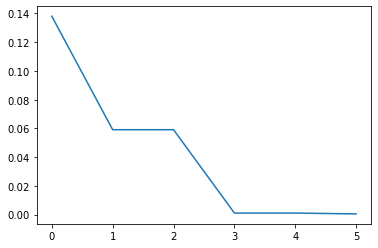

In [ ]:
import matplotlib.pyplot as plt
plt.plot(probs[0])

$\sigma=0.5$ works well here. In particular, the 45 degree angles have fairly high probability, while still being less than the probability of going straight.

This should look like a 3-dimensional pacman

In [ ]:
flow = torch.tensor([[1,1]]).float()
x, y = np.meshgrid(np.linspace(-5,5,20),np.linspace(-5,5,20))
x = torch.tensor(x,dtype=float).cpu()
y = torch.tensor(y,dtype=float).cpu()
xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()

In [ ]:
directions_array = xy_t.reshape(400,1,2)
flows = affinity_from_flow(flow, directions_array,flow_strength=2)

In [ ]:
length_of_directions = torch.linalg.norm(directions_array,dim=-1)
normed_directions = directions_array / length_of_directions[:,:,None]

In [ ]:
normed_directions.shape

torch.Size([400, 1, 2])

In [ ]:
flows = flows.reshape(20,20)

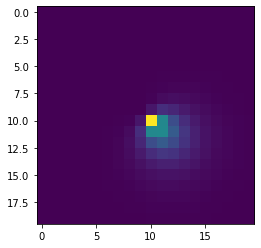

In [ ]:
plt.imshow(flows)

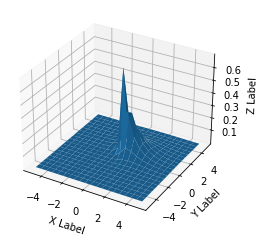

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(x,y,flows)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()

In [ ]:
torch.max(flows)

tensor(0.6892)

In [ ]:
X = np.column_stack([x.reshape(400),y.reshape(400),flows.reshape(400)*4])

In [ ]:
from directed_graphs.utils import plot_3d
plot_3d(X,distribution=flows.reshape(400),use_plotly=True)

## Computing Transition Probabilities Between a Grid and Points, and Vice Versa

The next functions will take three inputs: a set of points, a grid, and flows at each point and each point on the grid. It is tasked with returning three matrices: a transition matrix between the points and the grid, a transition matrix between the grid and the points, and the transition matrix from the grid to the grid.

These tasks should be separated, as each is called in different circumstances.
- The grid-to-point (and vv) function will be called each time the points are moved, or the grid is updated, or the flow is updated.
- The grid-to-grid function will be called whenever the grid is updated, or the flow is updated.

Both can be encapsulated in the same function, which computes an affinity matrix from pointset 1 to pointset 2.

The logic of the functions: 
1. For each point in set 1, sort the points in set 2 by distance.
2. Choose the $n$ nearest neighbors (optional computational boost), and compute the transition probabilities to them, storing the results in the affinity matrix.

In [ ]:
#export
def affinity_matrix_from_pointset_to_pointset(pointset1, pointset2, flows,n_neighbors=None,sigma=0.5, flow_strength=1):
  """Compute affinity matrix between the points of pointset1 and pointset2, using the provided flow.

  Parameters
  ----------
  pointset1 : torch tensor, n1 x d
      The first pointset, to calculate affinities *from*
  pointset2 : torch tensor, n2 x d
      The second pointset, to calculate affinities *to* (from pointset1)
  flow : a function that, when called at a point, gives the flow at that point
  n_neighbors : number of neighbors to include in affinity computations. All neighbors beyond it are given affinity zero
  (currently not implemented)

  Returns:
  Affinity matrix: torch tensor of shape n1 x n2
  """
  # Calculate the directions from point i in pointset 1 to point j in pointset 2
  n1 = pointset1.shape[0]
  n2 = pointset2.shape[0]
  P2 = pointset2[:,:,None].repeat(1,1,n1)
  P1 = pointset1.T.repeat(n2,1,1)
  P3 = (P2 - P1)
  P3 = P3.transpose(1,2)
  # dimension 1 represents directions to point i
  # dimension 2 represents direction from point j
  # dimension 3 represents direction in each dimension (R^n)
  # compute affinities from flows and directions
  affinities = affinity_from_flow(flows,P3,sigma=sigma,flow_strength=flow_strength)
  return affinities


### Building the function

This is an illustration of how the function should work.

In [ ]:
pointset1 = torch.rand(4,2)
pointset2 = torch.rand(7,2)
def flow(x):
  return x**2/torch.linalg.norm(x**2)

In [ ]:
pointset1

tensor([[0.8232, 0.7579],
        [0.4798, 0.5634],
        [0.7873, 0.1840],
        [0.8736, 0.4784]])

In [ ]:
pointset2

tensor([[0.8119, 0.9613],
        [0.9562, 0.3700],
        [0.9584, 0.7433],
        [0.6947, 0.9516],
        [0.3699, 0.4998],
        [0.9198, 0.7321],
        [0.9985, 0.3589]])

In [ ]:
pointset2[:,:,None]

tensor([[[0.8119],
         [0.9613]],

        [[0.9562],
         [0.3700]],

        [[0.9584],
         [0.7433]],

        [[0.6947],
         [0.9516]],

        [[0.3699],
         [0.4998]],

        [[0.9198],
         [0.7321]],

        [[0.9985],
         [0.3589]]])

In [ ]:
P2 = pointset2[:,:,None].repeat(1,1,4)
P2

tensor([[[0.8119, 0.8119, 0.8119, 0.8119],
         [0.9613, 0.9613, 0.9613, 0.9613]],

        [[0.9562, 0.9562, 0.9562, 0.9562],
         [0.3700, 0.3700, 0.3700, 0.3700]],

        [[0.9584, 0.9584, 0.9584, 0.9584],
         [0.7433, 0.7433, 0.7433, 0.7433]],

        [[0.6947, 0.6947, 0.6947, 0.6947],
         [0.9516, 0.9516, 0.9516, 0.9516]],

        [[0.3699, 0.3699, 0.3699, 0.3699],
         [0.4998, 0.4998, 0.4998, 0.4998]],

        [[0.9198, 0.9198, 0.9198, 0.9198],
         [0.7321, 0.7321, 0.7321, 0.7321]],

        [[0.9985, 0.9985, 0.9985, 0.9985],
         [0.3589, 0.3589, 0.3589, 0.3589]]])

In [ ]:
P1 = pointset1.T.repeat(7,1,1)
P1

tensor([[[0.8232, 0.4798, 0.7873, 0.8736],
         [0.7579, 0.5634, 0.1840, 0.4784]],

        [[0.8232, 0.4798, 0.7873, 0.8736],
         [0.7579, 0.5634, 0.1840, 0.4784]],

        [[0.8232, 0.4798, 0.7873, 0.8736],
         [0.7579, 0.5634, 0.1840, 0.4784]],

        [[0.8232, 0.4798, 0.7873, 0.8736],
         [0.7579, 0.5634, 0.1840, 0.4784]],

        [[0.8232, 0.4798, 0.7873, 0.8736],
         [0.7579, 0.5634, 0.1840, 0.4784]],

        [[0.8232, 0.4798, 0.7873, 0.8736],
         [0.7579, 0.5634, 0.1840, 0.4784]],

        [[0.8232, 0.4798, 0.7873, 0.8736],
         [0.7579, 0.5634, 0.1840, 0.4784]]])

In [ ]:
P3 = (P2-P1)
P3

tensor([[[-0.0113,  0.3321,  0.0245, -0.0617],
         [ 0.2033,  0.3979,  0.7773,  0.4828]],

        [[ 0.1330,  0.4764,  0.1688,  0.0826],
         [-0.3879, -0.1934,  0.1860, -0.1084]],

        [[ 0.1351,  0.4785,  0.1710,  0.0848],
         [-0.0147,  0.1799,  0.5593,  0.2648]],

        [[-0.1285,  0.2149, -0.0926, -0.1789],
         [ 0.1937,  0.3882,  0.7676,  0.4732]],

        [[-0.4533, -0.1099, -0.4174, -0.5036],
         [-0.2582, -0.0637,  0.3158,  0.0213]],

        [[ 0.0966,  0.4400,  0.1325,  0.0463],
         [-0.0259,  0.1687,  0.5481,  0.2537]],

        [[ 0.1753,  0.5187,  0.2112,  0.1250],
         [-0.3991, -0.2046,  0.1749, -0.1196]]])

In [ ]:
P3 = P3.transpose(1,2)
P3

tensor([[[-0.0113,  0.2033],
         [ 0.3321,  0.3979],
         [ 0.0245,  0.7773],
         [-0.0617,  0.4828]],

        [[ 0.1330, -0.3879],
         [ 0.4764, -0.1934],
         [ 0.1688,  0.1860],
         [ 0.0826, -0.1084]],

        [[ 0.1351, -0.0147],
         [ 0.4785,  0.1799],
         [ 0.1710,  0.5593],
         [ 0.0848,  0.2648]],

        [[-0.1285,  0.1937],
         [ 0.2149,  0.3882],
         [-0.0926,  0.7676],
         [-0.1789,  0.4732]],

        [[-0.4533, -0.2582],
         [-0.1099, -0.0637],
         [-0.4174,  0.3158],
         [-0.5036,  0.0213]],

        [[ 0.0966, -0.0259],
         [ 0.4400,  0.1687],
         [ 0.1325,  0.5481],
         [ 0.0463,  0.2537]],

        [[ 0.1753, -0.3991],
         [ 0.5187, -0.2046],
         [ 0.2112,  0.1749],
         [ 0.1250, -0.1196]]])

In [ ]:
P3.shape

torch.Size([7, 4, 2])

In [ ]:
flows = flow(pointset1)
flows

tensor([[0.4837, 0.4100],
        [0.1643, 0.2266],
        [0.4424, 0.0242],
        [0.5446, 0.1634]])

In [ ]:
A = affinity_from_flow(flows,P3)

In [ ]:
(P3 * flows).sum(-1)

tensor([[ 0.0779,  0.1447,  0.0296,  0.0453],
        [-0.0947,  0.0345,  0.0792,  0.0273],
        [ 0.0593,  0.1194,  0.0892,  0.0895],
        [ 0.0173,  0.1233, -0.0224, -0.0201],
        [-0.3251, -0.0325, -0.1771, -0.2708],
        [ 0.0361,  0.1105,  0.0719,  0.0666],
        [-0.0788,  0.0389,  0.0976,  0.0485]])

In [ ]:
torch.linalg.norm(flows,dim=1).repeat(4,1)

tensor([[0.6341, 0.2799, 0.4431, 0.5686],
        [0.6341, 0.2799, 0.4431, 0.5686],
        [0.6341, 0.2799, 0.4431, 0.5686],
        [0.6341, 0.2799, 0.4431, 0.5686]])

### Testing the function

In [ ]:
pointset1 = torch.rand(4,2)
pointset2 = torch.rand(7,2)
def flow(x):
  return 5*x**2 - 3*x


In [ ]:
P = affinity_matrix_from_pointset_to_pointset(pointset1,pointset2,flow(pointset1))

In [ ]:
P

tensor([[2.9359e-01, 2.9971e-01, 2.9305e-01, 2.9116e-01, 7.2561e-01, 3.6890e-01,
         3.6749e-01],
        [1.1764e-01, 1.3987e-01, 1.5075e-01, 9.6361e-02, 1.6802e-01, 1.0500e-01,
         1.0536e-01],
        [4.2554e-03, 2.6905e-03, 5.0466e-04, 7.5815e-03, 1.0698e-03, 1.4281e-03,
         1.5151e-03],
        [6.2051e-02, 8.0975e-02, 7.8449e-02, 4.4556e-02, 6.7392e-02, 4.0996e-02,
         4.1763e-02]])

In [ ]:
P.sum(axis=1)

tensor([2.6395, 0.8830, 0.0190, 0.4162])

In [ ]:
torch.diag(1/P.sum(axis=1)) @ P

tensor([[0.1112, 0.1135, 0.1110, 0.1103, 0.2749, 0.1398, 0.1392],
        [0.1332, 0.1584, 0.1707, 0.1091, 0.1903, 0.1189, 0.1193],
        [0.2234, 0.1413, 0.0265, 0.3981, 0.0562, 0.0750, 0.0796],
        [0.1491, 0.1946, 0.1885, 0.1071, 0.1619, 0.0985, 0.1003]])

# Putting the pieces together

## The Loss Function: KL Divergence

Previously, our network used a frobenius norm between matrices as the loss function. Now, it is comparing probability distributions, rather than distance matrices, and so we want something more robust. 

We'll start by using the simplest possible divergence: the KL Divergence

In [ ]:
loss = nn.KLDivLoss(reduction = 'batchmean',log_target = False)

In [ ]:
Pg = torch.rand(10,10)
Pe = torch.rand(10,10)
Pg_log = torch.log(Pg)

In [ ]:
loss(Pg_log,Pe)

tensor(3.1752)

### A Gaussian-based flow field

As defined in [Vector Field Neural Networks](x-devonthink-item://67DF5481-E16A-4D6C-90D5-C03CAF439BC5)

In [ ]:
#export
class GaussianVectorField(nn.Module):
  def __init__(self,n_dims, n_gaussians, device, random_initalization = True):
    super(GaussianVectorField, self).__init__()
    self.n_dims = n_dims
    # each gaussian has a mean and a variance, which are initialized randomly, but
    # are afterwards tuned by the network
    self.means = torch.nn.Parameter(torch.rand(n_gaussians,n_dims)*8 - 4).to(device)
    if random_initalization:
      vecs = torch.randn(n_gaussians,n_dims)
    else:
      vecs = torch.ones(n_gaussians,n_dims)
    vecs = vecs / torch.linalg.norm(vecs, dim=1)[:,None]
    self.vectors = torch.nn.Parameter(vecs).to(device)
  def forward(self,points):
    # evaluates the vector field at each point
    # First, take distances between the points and the means
    dist_between_pts_and_means = torch.cdist(points,self.means)
    # print("distances between points and means",dist_between_pts_and_means)
    # apply kernel to this
    # creates n_points x n_means array
    kernel_from_mean = torch.exp(-(dist_between_pts_and_means**2))
    # print("kernalized",kernel_from_mean)
    # multiply kernel value by vectors associated with each Gaussian
    kernel_repeated = kernel_from_mean[:,:,None].repeat(1,1,self.n_dims)
    # print('kernel repeated has shape',kernel_repeated.shape, 'and vecs has shape', self.vectors.shape)
    kernel_times_vectors = kernel_repeated * self.vectors
    # creates tensor of shape
    # n_points x n_means x n_dims
    # collapse along dim 1 to sum vectors along dimension
    vector_field = kernel_times_vectors.sum(dim=1)
    return vector_field
    

  


Testing this does as expected...

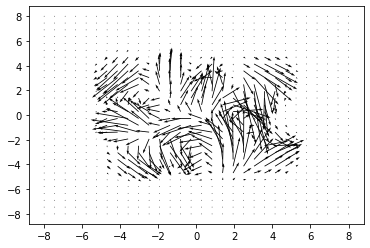

In [ ]:
K = GaussianVectorField(n_dims = 2, n_gaussians = 70, device = torch.device('cpu'), random_initalization=True)
x, y = np.meshgrid(np.linspace(-8,8,30),np.linspace(-8,8,30))
x = torch.tensor(x,dtype=float).cpu()
y = torch.tensor(y,dtype=float).cpu()
xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float().reshape(900,2)
uv = K(xy_t)
# uv[uv < 0.9] = 0
u = uv[:,0].detach()
v = uv[:,1].detach()
plt.quiver(x,y,u,v)
plt.show()



## PyTorch Anisotropic Kernel

In [ ]:
#export
def anisotropic_kernel(D, sigma=0.7, alpha = 1):
  """Computes anisotropic kernel of given distances matrix.

  Parameters
  ----------
  D : ndarray or sparse
  sigma : float, optional
      Kernel bandwidth, by default 0.7
  alpha : int, optional
      Degree of density normalization, from 0 to 1; by default 1
  This is a good function.
  """
  W = torch.exp(-D**2/(2*sigma**2))
  # Additional normalization step for density
  D = torch.diag(1/(torch.sum(W,axis=1)**alpha)) 
  W = D @ W @ D
  return W

## Flow Artist (Flexible Function)

In [ ]:
# export
from collections import OrderedDict
import torch
def FlowArtist(FA_type,dim = 2, num_gauss = 0, shape = [2,4,8,4,2], device = torch.device('cpu')):
    # Function to create tailored flow artist
    
    FA = nn.Sequential()
    
    if FA_type == "gaussian": # default = Gaussian model
        FA = GaussianVectorField(dim,num_gauss, device=device)
    elif FA_type == "ReLU": # ReLu
        d_len = len(shape)*2
        d = OrderedDict()
        d[str(0)] = nn.Linear(shape[0], shape[1])
        for i in range(1,d_len-3):
            if i%2 == 1:
                d[str(i)] = nn.LeakyReLU()
            else:
                d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
        # create MLP
        FA = nn.Sequential(d)
        
    elif FA_type == "tanh": # ReLu dim,2,4,8,4,2,dim
        shape = [2,4,8,4,2]
        FA = nn.Sequential(nn.Linear(dim, shape[0]),
                           nn.tanh(),
                           nn.Linear(shape[0], shape[1]),
                           nn.tanh(),
                           nn.Linear(shape[1], shape[2]),
                           nn.tanh(),
                           nn.Linear(shape[2], shape[3]),
                           nn.tanh(),
                           nn.Linear(shape[3], shape[4]),
                           nn.tanh(),
                           nn.Linear(shape[4], dim))
        
    return FA

## Smoothness Regularization
We want our vector field to be as simple as possible. One means of achieving this is to regularize it by smoothness, to penalize it for changing the direction of the vectors too suddenly. Here, I'll code up a grid-based laplacian normalizer. It will take samples from a grid graph in the support of the points and flow, calculate the  laplacian of the grid, and compute the smoothness via
$$ \frac{v^T L v}{v^T v} $$

In [ ]:
# export
def smoothness_of_vector_field(embedded_points, vector_field_function, device, use_grid = True, grid_width = 20):
  if use_grid:
    # find support of points
    minx = (min(embedded_points[:,0])-1).detach()
    maxx = (max(embedded_points[:,0])+1).detach()
    miny = (min(embedded_points[:,1])-1).detach()
    maxy = (max(embedded_points[:,1])+1).detach()
    # form grid around points
    x, y = torch.meshgrid(torch.linspace(minx,maxx,steps=grid_width),torch.linspace(miny,maxy,steps=grid_width))
    xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()
    xy_t = xy_t.reshape(grid_width**2,2).to(device)
    points_to_test = xy_t
  else:
    points_to_test = embedded_points
  # Compute distances between points
  # TODO: Can compute A analytically for grid graph, don't need to run kernel
  Dists = torch.cdist(points_to_test,points_to_test)
  A = anisotropic_kernel(Dists)
  # Get degree matrix and build graph laplacian
  D = A.sum(axis=1)
  L = torch.diag(D) - A
  # comment this out in production
  # plt.imshow(L)
  # print(L)
  # compute vector field at each grid point
  vecs = vector_field_function(points_to_test)
  x_vecs = vecs[:,0]
  y_vecs = vecs[:,1]
  # compute smoothness of each x and y and add them # TODO: There are other ways this could be done
  x_smoothness = (x_vecs.T @ L @ x_vecs) / torch.max(torch.linalg.norm(x_vecs)**2, torch.tensor(1e-5))
  y_smoothness = (y_vecs.T @ L @ y_vecs) / torch.max(torch.linalg.norm(y_vecs)**2, torch.tensor(1e-5))
  total_smoothness = x_smoothness + y_smoothness
  return total_smoothness

Testing this on a grid with random data and flows, vs uniform grid and flows:

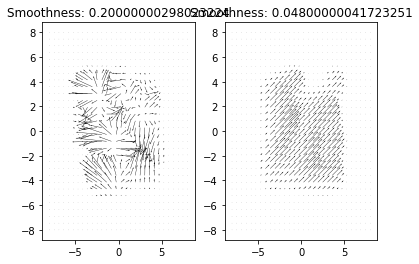

In [ ]:
K = GaussianVectorField(n_dims = 2, n_gaussians = 70, device = torch.device('cpu'), random_initalization=True)
x, y = np.meshgrid(np.linspace(-8,8,30),np.linspace(-8,8,30))
x = torch.tensor(x,dtype=float).cpu()
y = torch.tensor(y,dtype=float).cpu()
random_data = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float().reshape(900,2)

Kuni = GaussianVectorField(n_dims = 2, n_gaussians = 70, device = torch.device('cpu'), random_initalization=False)

random_smoothness = smoothness_of_vector_field(random_data,K, device = torch.device('cpu'), use_grid=True)
uniform_smoothness = smoothness_of_vector_field(random_data,Kuni, device = torch.device('cpu'), use_grid=True)

uv = K(random_data)
# uv[uv < 0.9] = 0
u = uv[:,0].detach()
v = uv[:,1].detach()

uv_uni = Kuni(random_data)
# uv[uv < 0.9] = 0
u_uni = uv_uni[:,0].detach()
v_uni = uv_uni[:,1].detach()

fig, axs = plt.subplots(1,2)
axs[0].quiver(x,y,u,v)
axs[0].set_title(f"Smoothness: {torch.round(random_smoothness,decimals=1)}")

axs[1].quiver(x,y,u_uni,v_uni)
axs[1].set_title(f"Smoothness: {torch.round(uniform_smoothness,decimals=4)}")
assert uniform_smoothness < random_smoothness

plt.show()

Now to put the pieces together, into a `FlowEmbedder` Network!

In [ ]:
# export
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt


class DiffusionFlowEmbedder(torch.nn.Module):
    def __init__(
        self,
        X,
        flows,
        t=1,
        sigma_graph=0.5,
        sigma_embedding=0.5,
        embedding_dimension=2,
        device=torch.device("cpu"),
        autoencoder_shape=[10, 10],
        flow_artist="gaussian",
        flow_artist_shape=[30, 20, 10],
        flow_strength_graph=5,
        flow_strength_embedding=5,
        learnable_flow_strength=True,
        multiscale_loss=True,
        weight_of_flow=0.5,
        learning_rate=1e-5,
        smoothness=1,
        embedding_bounds=4,
        num_gaussians=25,
        labels=None,
    ):
        """Flow Embedding with diffusion

        Parameters
        ----------
        X : torch tensor n_points x n_dim
                data matrix
        flows : torch tensor n_points x n_dim
                The flow at each point
        t : int
                Loss is computed with the diffusion operator powered to this number
        sigma in [0,1]
                Kernel bandwidth in the embedding
        """
        # initialize parameters
        super(DiffusionFlowEmbedder, self).__init__()
        self.X = X
        self.ground_truth_flows = flows
        self.t = t
        self.sigma_embedding = sigma_embedding
        self.sigma_graph = sigma_graph
        self.nnodes = X.shape[0]
        self.data_dimension = X.shape[1]
        self.losses = []
        self.eps = 0.001
        self.weight_of_flow = weight_of_flow
        self.smoothness = smoothness
        self.embedding_bounds = embedding_bounds  # will constrain embedding to live in -n, n in each dimension
        self.labels = labels

        if learnable_flow_strength:
            self.flow_strength = nn.Parameter(
                torch.tensor(flow_strength_embedding).float()
            )
        else:
            self.flow_strength = flow_strength_embedding

        self.embedding_dimension = embedding_dimension
        # set device (used for shuffling points around during visualization)
        self.device = device
        # Compute P^t of the graph, the powered diffusion matrix
        # TODO: This can be optimized using landmarks, etc. For now it's straight sparse matrix multiplication
        # TODO: Migrate to a specialized function for dataset affinity calculation, with automatic kernel bandwidth selection, and the like

        self.P_graph = affinity_matrix_from_pointset_to_pointset(
            X, X, flows, sigma=sigma_graph, flow_strength=flow_strength_graph
        )
        # self.P_graph = torch.diag(1/self.P_graph.sum(axis=1)) @ self.P_graph
        self.P_graph = F.normalize(self.P_graph, p=1, dim=1)
        self.P_graph_t = torch.matrix_power(self.P_graph, self.t)

        if multiscale_loss:
            self.P_embedding_multiscale = [0, 0, 0, 0]

        # Flow field
        # Gaussian model
        self.FlowArtist = FlowArtist(
            FA_type=flow_artist,
            dim=self.embedding_dimension,
            num_gauss=num_gaussians,
            device=device,
        )
        # Autoencoder to embed the points into a low dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.data_dimension, autoencoder_shape[0]),
            nn.LeakyReLU(),
            nn.Linear(autoencoder_shape[0], autoencoder_shape[1]),
            nn.LeakyReLU(),
            nn.Linear(autoencoder_shape[1], self.embedding_dimension),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.embedding_dimension, autoencoder_shape[1]),
            nn.LeakyReLU(),
            nn.Linear(autoencoder_shape[1], autoencoder_shape[0]),
            nn.LeakyReLU(),
            nn.Linear(autoencoder_shape[0], self.data_dimension),
        )
        # training ops
        self.KLD = nn.KLDivLoss(reduction="batchmean", log_target=False)
        self.MSE = nn.MSELoss()
        # testing
        # self.KLD = nn.NLLLoss()
        self.optim = torch.optim.Adam(
            self.parameters(),
            lr=learning_rate,
        )

    def compute_embedding_P(self):
        A = affinity_matrix_from_pointset_to_pointset(
            self.embedded_points,
            self.embedded_points,
            flows=self.FlowArtist(self.embedded_points),
            sigma=self.sigma_embedding,
            flow_strength=self.flow_strength,
        )
        # print("affinities ",A)
        # flow
        self.P_embedding = F.normalize(A, p=1, dim=1)
        # power it
        self.P_embedding_t = torch.matrix_power(self.P_embedding, self.t)

    def loss(self):
        self.embedded_points = self.encoder(self.X)
        # normalize embedded points to lie within -self.embedding_bounds, self.embedding_bounds
        # if any are trying to escape, constrain them to lie on the edges
        # self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])
        # self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])
        # print(self.embedded_points)
        # compute embedding diffusion matrix
        self.compute_embedding_P()
        # compute autoencoder loss
        X_reconstructed = self.decoder(self.embedded_points)
        reconstruction_loss = self.MSE(X_reconstructed, self.X)
        # print("recon loss",reconstruction_loss)
        # take KL divergence between it and actual P
        # print("embedding p",self.P_embedding_t)
        log_P_embedding_t = torch.log(self.P_embedding_t)
        # print(log_P_embedding_t)
        if log_P_embedding_t.is_sparse:
            diffusion_loss = self.KLD(
                log_P_embedding_t.to_dense(), self.P_graph_t.to_dense()
            )
        else:
            diffusion_loss = self.KLD(log_P_embedding_t, self.P_graph_t)
        # print("diffusion loss is",diffusion_loss)
        smoothness_loss = self.smoothness * smoothness_of_vector_field(
            self.embedded_points, self.FlowArtist, device=self.device, grid_width=20
        )
        cost = (
            self.weight_of_flow * diffusion_loss
            + (1 - self.weight_of_flow) * reconstruction_loss
            + smoothness_loss
        )
        # print(f"cost is KLD {diffusion_loss} with recon {reconstruction_loss}")
        self.losses.append([diffusion_loss, reconstruction_loss, smoothness_loss])
        return cost

    def visualize_points(self, labels=None):
        # controls the x and y axes of the plot
        # linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
        if labels is None:
            labels = self.labels
        minx = min(self.embedded_points[:, 0].detach().cpu().numpy()) - 1
        maxx = max(self.embedded_points[:, 0].detach().cpu().numpy()) + 1
        miny = min(self.embedded_points[:, 1].detach().cpu().numpy()) - 1
        maxy = max(self.embedded_points[:, 1].detach().cpu().numpy()) + 1
        num_grid = 20
        x, y = np.meshgrid(
            np.linspace(minx, maxx, num_grid), np.linspace(miny, maxy, num_grid)
        )
        x = torch.tensor(x, dtype=float).cpu()
        y = torch.tensor(y, dtype=float).cpu()
        xy_t = (
            torch.concat([x[:, :, None], y[:, :, None]], dim=2).float().to(self.device)
        )  # TODO: cuda/cpu issue
        xy_t = xy_t.reshape(num_grid**2, 2)
        uv = self.FlowArtist(xy_t).detach()
        u = uv[:, 0].cpu()
        v = uv[:, 1].cpu()

        # quiver
        # 	plots a 2D field of arrows
        # 	quiver([X, Y], U, V, [C], **kw);
        # 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
        if labels is not None:
            sc = plt.scatter(
                self.embedded_points[:, 0].detach().cpu(),
                self.embedded_points[:, 1].detach().cpu(),
                c=labels,
            )
            plt.legend()
        else:
            sc = plt.scatter(
                self.embedded_points[:, 0].detach().cpu(),
                self.embedded_points[:, 1].detach().cpu(),
            )
        plt.suptitle("Flow Embedding")
        plt.quiver(x, y, u, v)
        # Display all open figures.
        plt.show()

    def visualize_diffusion_matrices(self):
        fig, axs = plt.subplots(1, 2)
        axs[0].set_title(f"Ambient $P^{self.t}$")
        axs[0].imshow(self.P_graph_t.detach().cpu().numpy())
        axs[1].set_title(f"Embedding $P^{self.t}$")
        axs[1].imshow(self.P_embedding_t.detach().cpu().numpy())
        plt.show()

    def fit(self, n_steps=1000):
        # train Flow Embedder on the provided graph
        self.train()
        # self.weight_of_flow = 0
        for step in trange(n_steps):
            # if step == 100:
            # 	self.weight_of_flow = 1
            # if step == 200:
            # 	self.weight_of_flow = 0.5
            self.optim.zero_grad()
            # compute loss
            loss = self.loss()
            # print("loss is ",loss)
            # compute gradient and step backwards
            loss.backward()
            self.optim.step()
            if step % 100 == 0:
                print(
                    f"EPOCH {step}. Loss {loss}. Flow strength {self.flow_strength}. Weight of flow {self.weight_of_flow} Heatmap of P embedding is "
                )
                self.visualize_diffusion_matrices()
                self.visualize_points()
            # TODO: Criteria to automatically end training
        print("Exiting training with loss ", loss)
        return self.embedded_points

In [ ]:
!nbdev_build_lib

Converted 00_core.ipynb.
Converted 01d Batch Testing Scripts.ipynb.
Converted 01e01 JSON Testing Script.ipynb.
Converted 02c Trees.ipynb.
Converted 02d01_Snake_TestCase.ipynb.
Converted 02d01a_Snake_With5b.ipynb.
Converted 02d02 Circles and Swiss roll Datasets.ipynb.
Converted 02d02a Testing Diffusion Flow Embedder on Circle and Swiss Roll.ipynb.
Converted 02d03 Spheres and Donuts with Flow (datasets).ipynb.
Converted 02d04 Tree and Flow Artist Test.ipynb.
Converted 02d05 Branch and Clusters.ipynb.
Converted 02d05a Testing Branch Clusters Circle Swiss roll.ipynb.
Converted 04a UW on RNA Data.ipynb.
Converted 05a Testing Distance-based Flow Embedder.ipynb.
Converted 05a01 Flow_Embedding_with_Implicit_Vectors.ipynb.
Converted 05a02 Model Spaces for Flow Embeddings.ipynb.
Converted 05b Flow Embedding with Diffusion.ipynb.
Converted 05b01 Testing diffusion flow embedder.ipynb.
Converted 05b01a Diffusion Flow Embedding on Pancreas_RNA_Velocity.ipynb.
Converted 05b01a01 RNA Velocity Analysis